In [2]:
import numpy as np
import pandas as pd
import time

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pathlib import Path

#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk("input"):
    print(dirname)

input
input\evaluation
input\test
input\training


In [3]:
#data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
data_path = Path('input/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'
training_tasks = sorted(os.listdir(training_path))
eval_tasks = sorted(os.listdir(evaluation_path))

In [4]:
#已解決的ID
solved_id=set()
solved_eva_id=set()

In [5]:
T = training_tasks
Trains = []
for i in range(400):
    task_file = str(training_path / T[i])
    task = json.load(open(task_file, 'r'))
    Trains.append(task)
    
E = eval_tasks
Evals= []
for i in range(400):
    task_file = str(evaluation_path / E[i])
    task = json.load(open(task_file, 'r'))
    Evals.append(task)

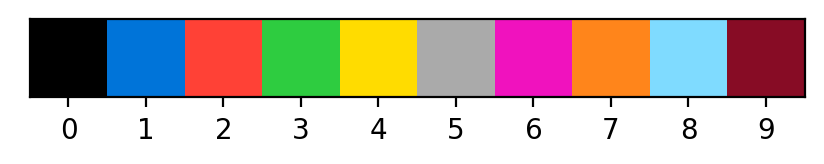

In [6]:
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow,
# 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=50)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()

In [7]:

def plot_picture(x):
    plt.imshow(np.array(x), cmap = cmap, norm = norm)
    plt.show()

In [8]:
def Defensive_Copy(A): 
    if type(A)!=list:
        A=A.tolist()
    n = len(A)
    k = len(A[0])
    L = np.zeros((n,k), dtype = int)
    for i in range(n):
        for j in range(k):
            L[i,j] = 0 + A[i][j]
    return L.tolist()

In [9]:
def Create(task, task_id = 0):
    n = len(task['train'])
    Input = [Defensive_Copy(task['train'][i]['input']) for i in range(n)]
    Output = [Defensive_Copy(task['train'][i]['output']) for i in range(n)]
    Input.append(Defensive_Copy(task['test'][task_id]['input']))
    return Input, Output

In [23]:
def getObjectHash(pixmap):
    flat = pixmap.flatten().astype(np.bool)
    mult = np.array([2 ** x for x in range(len(flat))])
    return np.sum(flat * mult)
#經測試沒有overflow問題
def groupByColor(pixmap):
    nb_colors = int(pixmap.max()) + 1
    splited = [(pixmap == i) * i for i in range(1, nb_colors)]
    return [x for x in splited if np.any(x)]
def checkColorMap(a0,b0):
    a=np.array(a0)
    b=np.array(b0)
    a[a==0]=10
    b[b==0]=10
    c = 1
    inp_hashes = sorted([getObjectHash(pm) for pm in groupByColor(a)])
    out_hashes = sorted([getObjectHash(pm) for pm in groupByColor(b)])
    c *= inp_hashes == out_hashes
    return bool(c)
def findColorMap(a,b):
    colormap = {}
    a1=np.array(a).flatten()
    b1=np.array(b).flatten()
    for col, idx in zip(*np.unique(a1,return_index=True)):
        if col in colormap.keys(): continue
        colormap[col] = b1[idx]
    return colormap
def applyColorMap(pixmap, colormap):
    a1=np.array(pixmap)
    for i in range(a1.shape[0]):
        for j in range(a1.shape[1]):
            if a1[i][j] not in colormap: #
                continue #
            a1[i][j]=colormap[pixmap[i][j]]
    return a1.tolist()
def mergedict(dict1):
    dict3={}
    for dict2 in dict1:
        for key in dict2.keys():
            if key not in dict3.keys():
                dict3[key]=dict2[key]
            elif dict3[key]!= dict2[key]:
                return False
    return dict3

BACKGROUND=0
def _get_bound(img0):
    img=np.array(img0)
    h, w = img.shape
    x0 = w - 1
    x1 = 0
    y0 = h - 1
    y1 = 0
    for x in range(w):
        for y in range(h):
            if img[y, x] == BACKGROUND:
                continue
            x0 = min(x0, x)
            x1 = max(x1, x)
            y0 = min(y0, y)
            y1 = max(y1, y)
    return x0, x1, y0, y1
def get_bound_image(img0):
    x0,x1,y0,y1=_get_bound(img0)
    img=np.array(img0)
    return img[y0:y1+1,x0:x1+1].tolist()


_neighbor_offsets = {
    4: [(1, 0), (-1, 0), (0, 1), (0, -1)],
    8: [(1, 0), (-1, 0), (0, 1), (0, -1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
}
def _expand_region_indices(img, i, j, neighbor=4):
    h, w = img.shape
    seed_color = img[i, j]
    idx = np.zeros_like(img, dtype=np.bool)
    region = []
    region.append((i, j))
    while len(region) > 0:
        ii, jj = region.pop()
        if img[ii, jj] != seed_color:
            continue
        idx[ii, jj] = True
        for di, dj in _neighbor_offsets[neighbor]:
            ni, nj = ii + di, jj + dj
            if ni >= 0 and ni < h and nj >= 0 and nj < w \
                    and not idx[ni, nj]:
                region.append((ni, nj))
    return idx
def _expand_region_indices01(img, i, j, neighbor=4):
    h, w = img.shape
    seed_color = 1
    idx = np.zeros_like(img, dtype=np.bool)
    region = []
    region.append((i, j))
    while len(region) > 0:
        ii, jj = region.pop()
        if img[ii, jj] == 0:
            continue
        idx[ii, jj] = True
        for di, dj in _neighbor_offsets[neighbor]:
            ni, nj = ii + di, jj + dj
            if ni >= 0 and ni < h and nj >= 0 and nj < w \
                    and not idx[ni, nj]:
                region.append((ni, nj))
    return idx
def _split_conn(img0, neighbor=4):
    regions = []
    img=np.array(img0)
    mem = np.zeros_like(img, dtype=np.bool)
    h, w = img.shape
    for j in range(w):
        for i in range(h):
            p = img[i, j]
            if p == BACKGROUND or mem[i, j]:
                continue
            conn_idx = _expand_region_indices(img, i, j, neighbor)
            mem[conn_idx] = True
            regions.append((np.where(conn_idx, img, BACKGROUND)).tolist())
    return regions
def _split_conn01(img0, neighbor=4):
    regions = []
    img=np.array(img0)
    mem = np.zeros_like(img, dtype=np.bool)
    h, w = img.shape
    for j in range(w):
        for i in range(h):
            p = img[i, j]
            if p == BACKGROUND or mem[i, j]:
                continue
            conn_idx = _expand_region_indices01(img, i, j, neighbor)
            mem[conn_idx] = True
            regions.append((np.where(conn_idx, img, BACKGROUND)).tolist())
    return regions
def split_conn(img): 
    ''' Split an image into a list of images each containing a single connected region'''
    
    return _split_conn(img, 4)
def split_conn8(img):
    ''' Split an image into a list of images each containing a single connected region.
      Pixels of 8 neighbors are all considered "connected"
    '''
    
    return _split_conn(img, 8)

def split_conn01(img): 
    ''' Split an image into a list of images each containing a single connected region'''
    
    return _split_conn01(img, 4)
def split_conn801(img):
    ''' Split an image into a list of images each containing a single connected region.
      Pixels of 8 neighbors are all considered "connected"
    '''
    
    return _split_conn01(img, 8)

def _split_object(img0, neighbor=4):
    regions = []
    img=np.array(img0)
    mem = np.zeros_like(img, dtype=np.bool)
    h, w = img.shape
    for j in range(w):
        for i in range(h):
            p = img[i, j]
            if p == BACKGROUND or mem[i, j]:
                continue
            conn_idx = _expand_region_indices(img, i, j, neighbor)
            mem[conn_idx] = True
            splitimage=np.where(conn_idx, img, BACKGROUND)
#             minx=0
#             miny=0
#             maxx=0
#             maxy=0
#             for m in range(h):
#                 if sum(splitimage[m,:])!=0:
#                     miny=m
#                     break
#             for n in range(w):
#                 if sum(splitimage[:,n])!=0:
#                     minx=n
#                     break
#             for m in range(h-1,-1,-1):
#                 if sum(splitimage[m,:])!=0:
#                     maxy=m
#                     break
#             for n in range(w-1,-1,-1):
#                 if sum(splitimage[:,n])!=0:
#                     maxx=n
#                     break
            (minx,maxx,miny,maxy)=_get_bound(splitimage)
            split_object=(splitimage[miny:maxy+1,minx:maxx+1]).tolist()
            
            
            regions.append({'start': (miny, minx), 'obj':split_object})
    return regions

def _split_object01(img0, neighbor=4):
    regions = []
    img=np.array(img0)
    mem = np.zeros_like(img, dtype=np.bool)
    h, w = img.shape
    for j in range(w):
        for i in range(h):
            p = img[i, j]
            if p == BACKGROUND or mem[i, j]:
                continue
            conn_idx = _expand_region_indices01(img, i, j, neighbor)
            mem[conn_idx] = True
            splitimage=np.where(conn_idx, img, BACKGROUND)
#             minx=0
#             miny=0
#             maxx=0
#             maxy=0
#             for m in range(h):
#                 if sum(splitimage[m,:])!=0:
#                     miny=m
#                     break
#             for n in range(w):
#                 if sum(splitimage[:,n])!=0:
#                     minx=n
#                     break
#             for m in range(h-1,-1,-1):
#                 if sum(splitimage[m,:])!=0:
#                     maxy=m 
#                     break
#             for n in range(w-1,-1,-1):
#                 if sum(splitimage[:,n])!=0:
#                     maxx=n
#                     break
        
            (minx,maxx,miny,maxy)=_get_bound(splitimage)
            split_object=(splitimage[miny:maxy+1,minx:maxx+1]).tolist()
            
            
            regions.append({'start': (miny, minx), 'obj':split_object})
    return regions
def split_color(img0): 
    
    img=np.array(img0)
    color = np.unique(img)
    return [np.where(img == c, c, 0) for c in color if c != BACKGROUND]
def split_color_crop(img0): 
    color_image=[]
    img=np.array(img0)
    color = np.unique(img)
    for c in color:
        if c!=BACKGROUND:
            imgc=np.where(img == c, c, 0)
            x0, x1, y0, y1=_get_bound(imgc)
            imgc=(imgc[y0:y1+1,x0:x1+1]).tolist()
            color_image.append(imgc)
    
    
    return color_image
def split_object(img):
    return _split_object(img, neighbor=4)
def split_object8(img):
    return _split_object(img, neighbor=8)
def split_object01(img):
    return _split_object01(img, neighbor=4)
def split_object801(img):
    return _split_object01(img, neighbor=8)

In [10]:
def search_same_output(basic_task):
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    list1=[]
    for x, y in zip(Input,Output):
        if y not in list1:
            list1.append(y)
        else:
            return True
    return -1

25 0


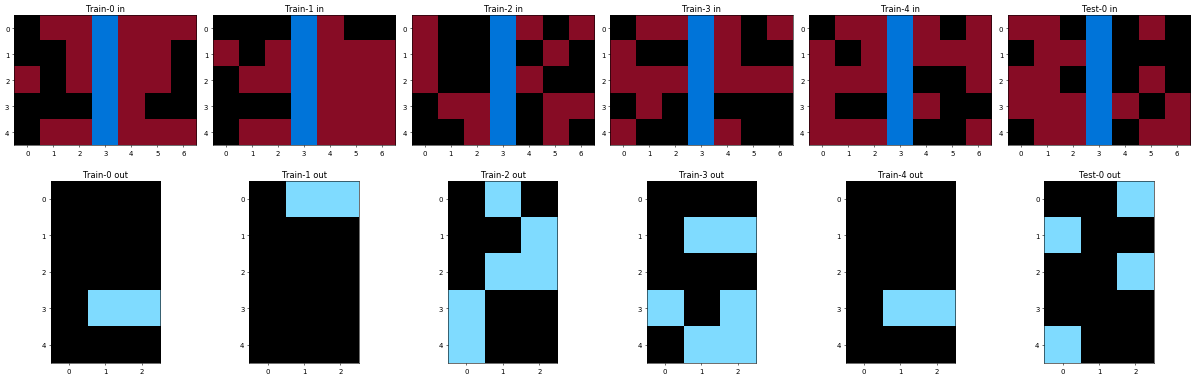

37 0


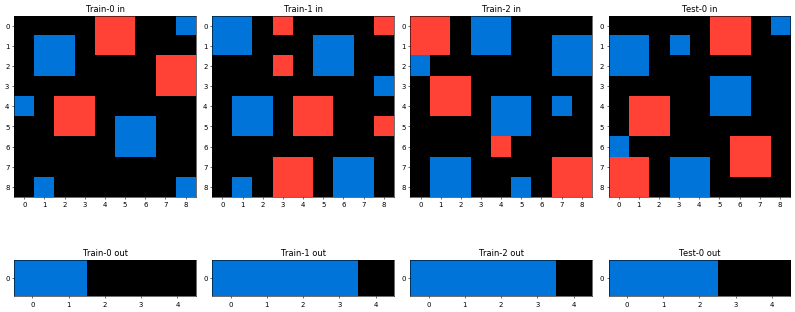

47 0


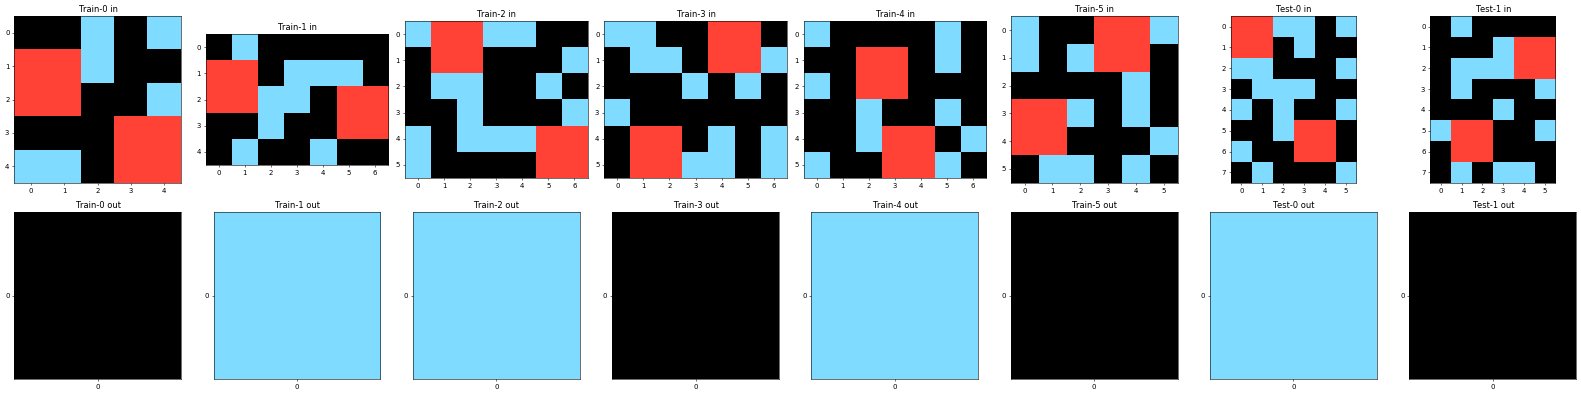

47 1


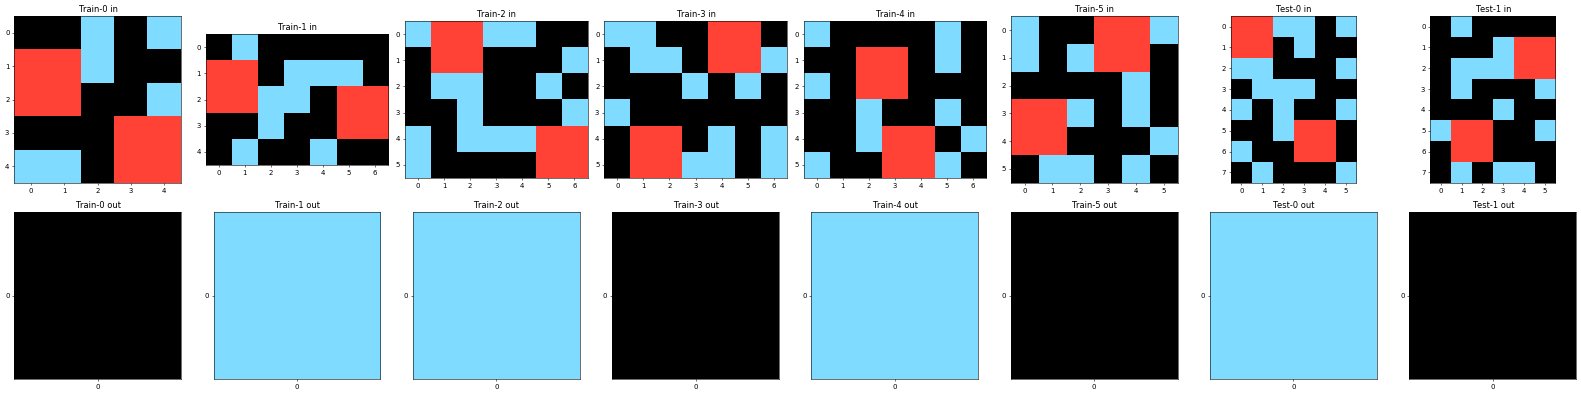

55 0


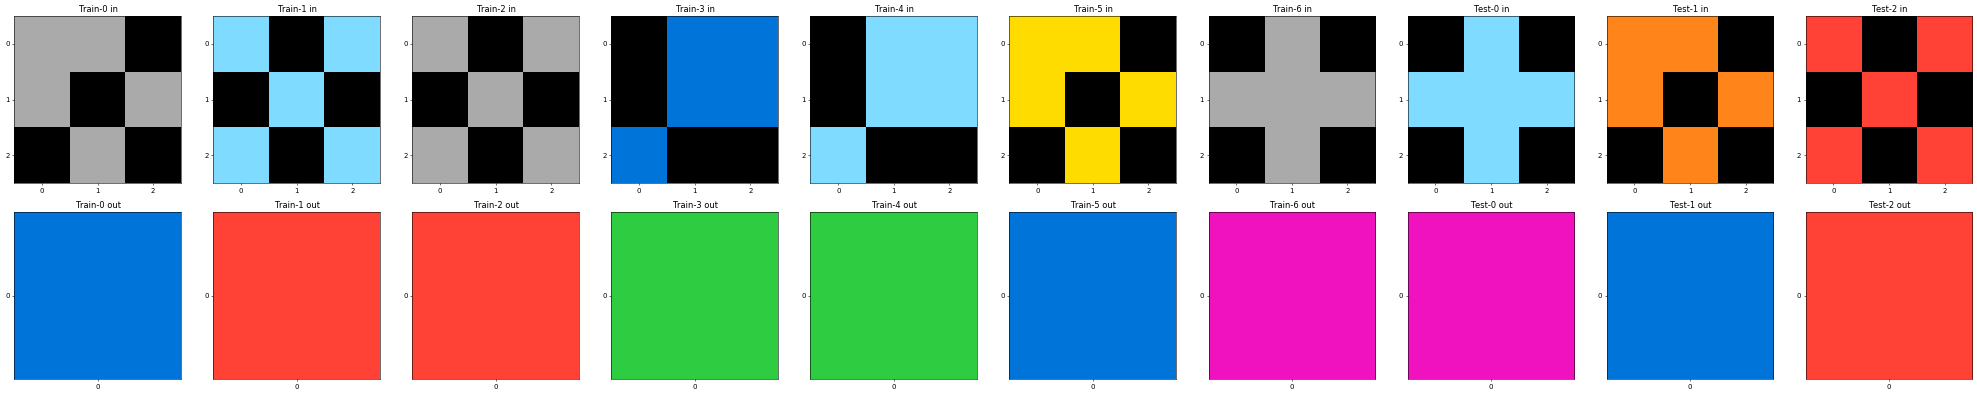

55 1


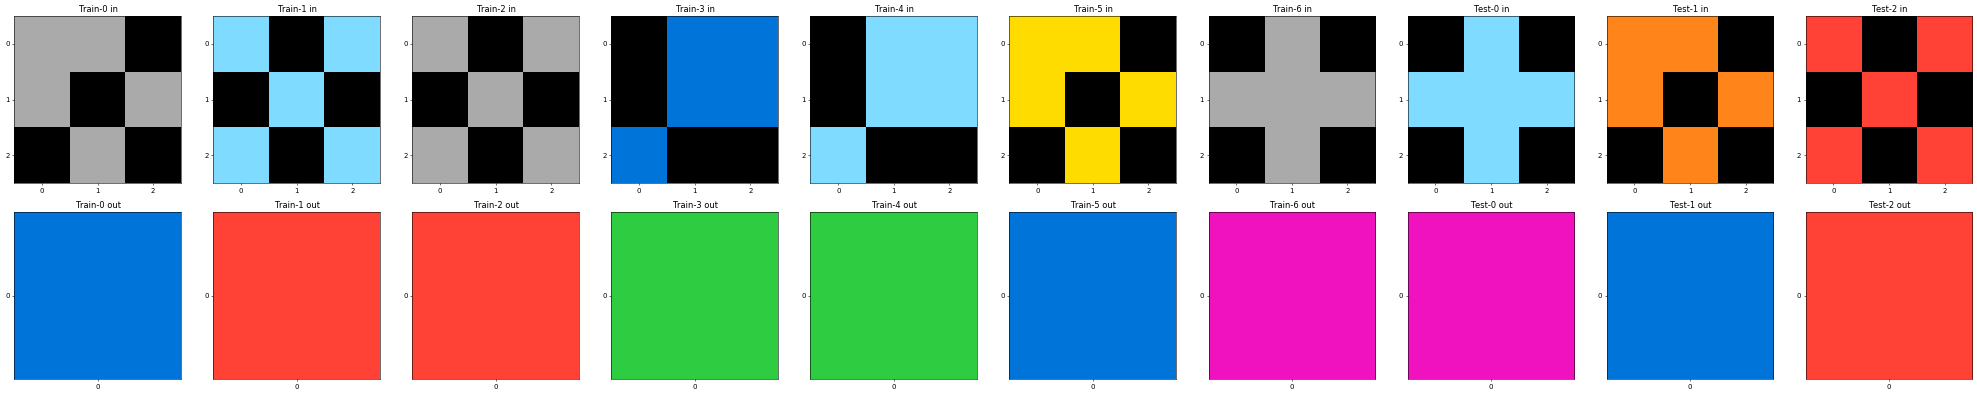

55 2


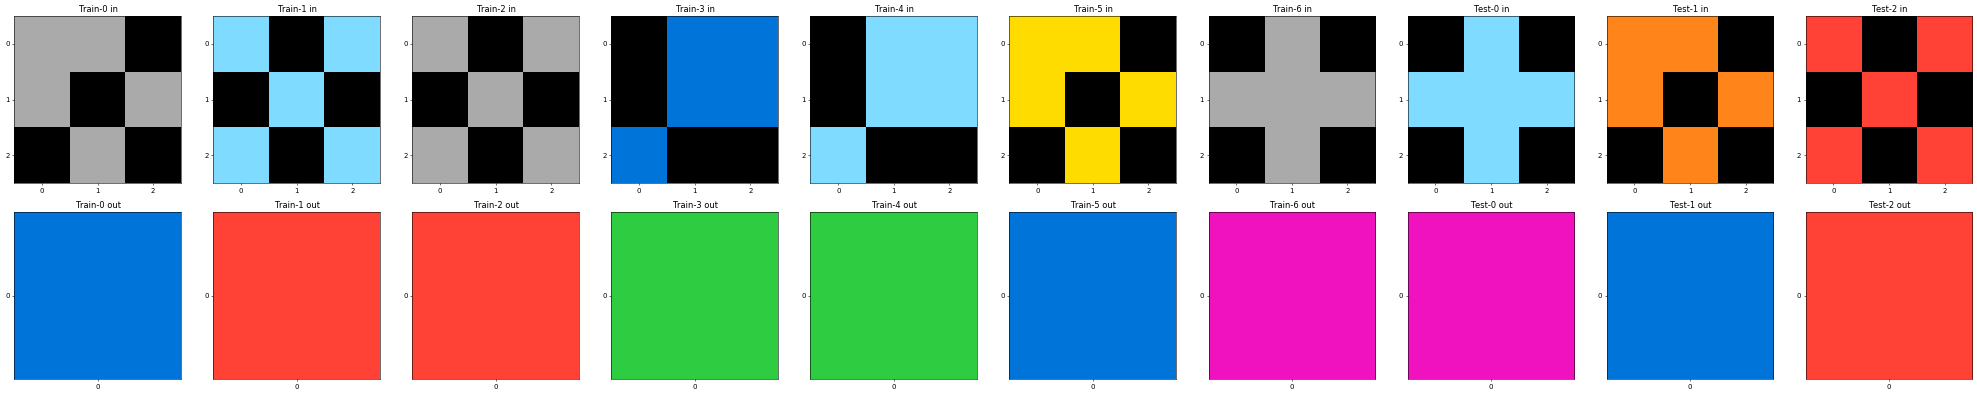

102 0


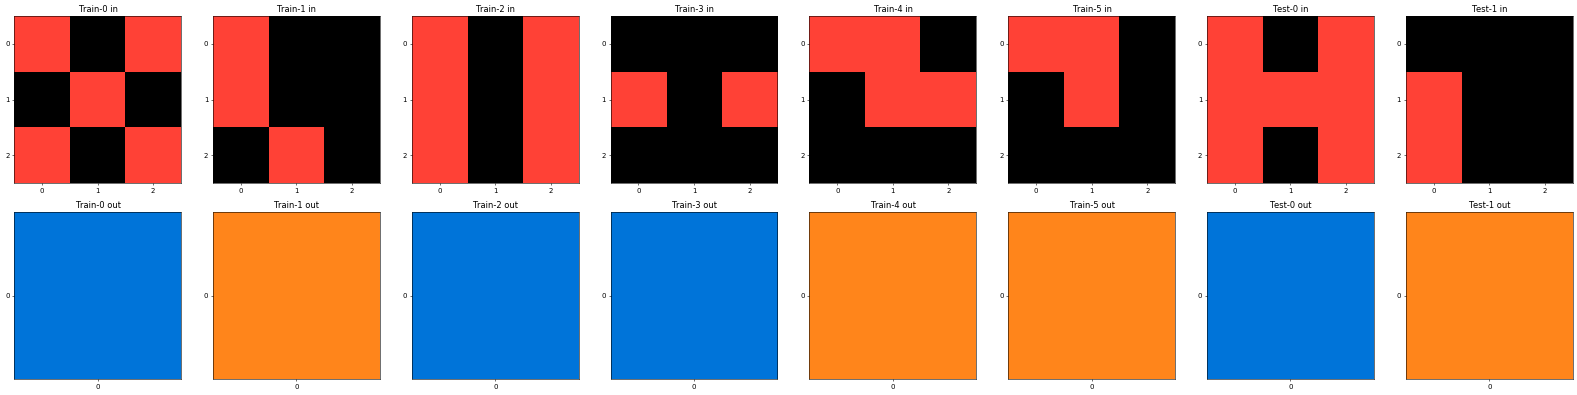

102 1


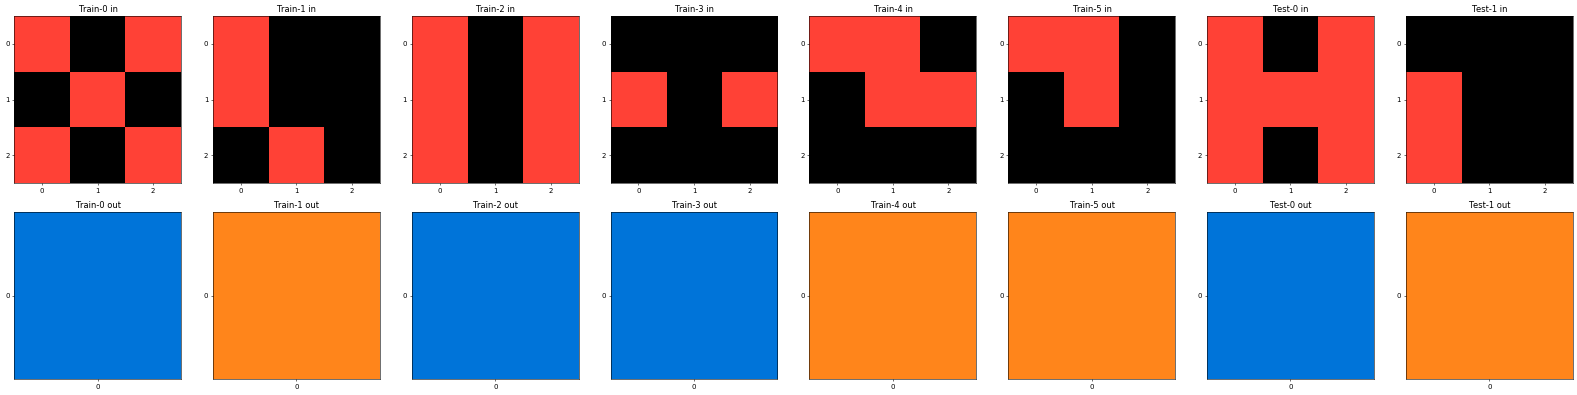

166 0


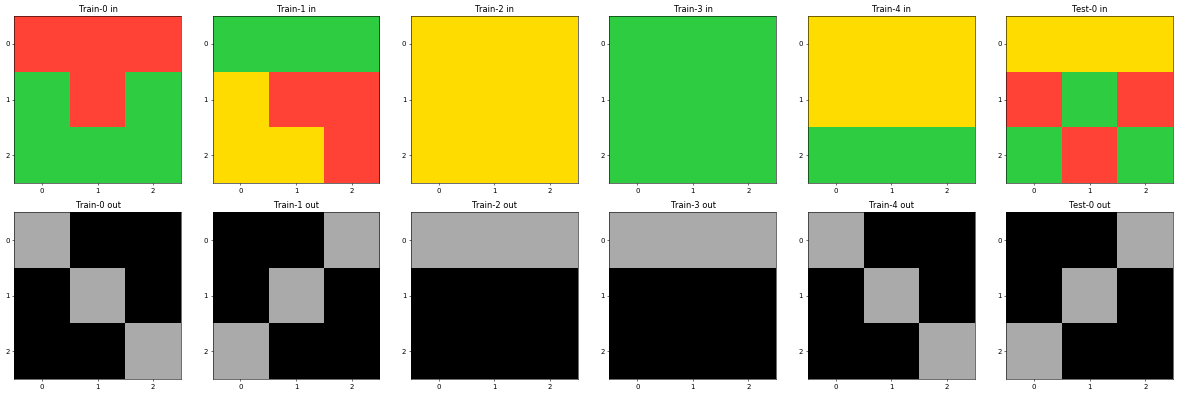

185 0


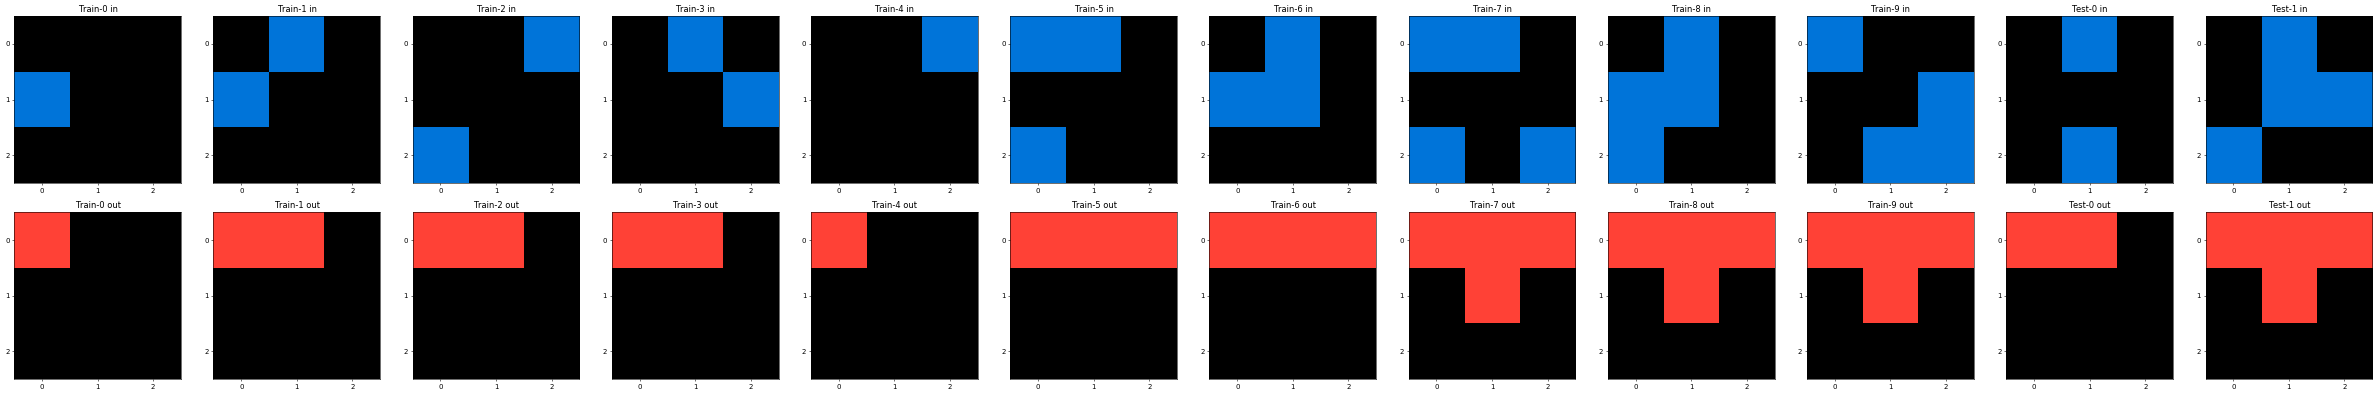

185 1


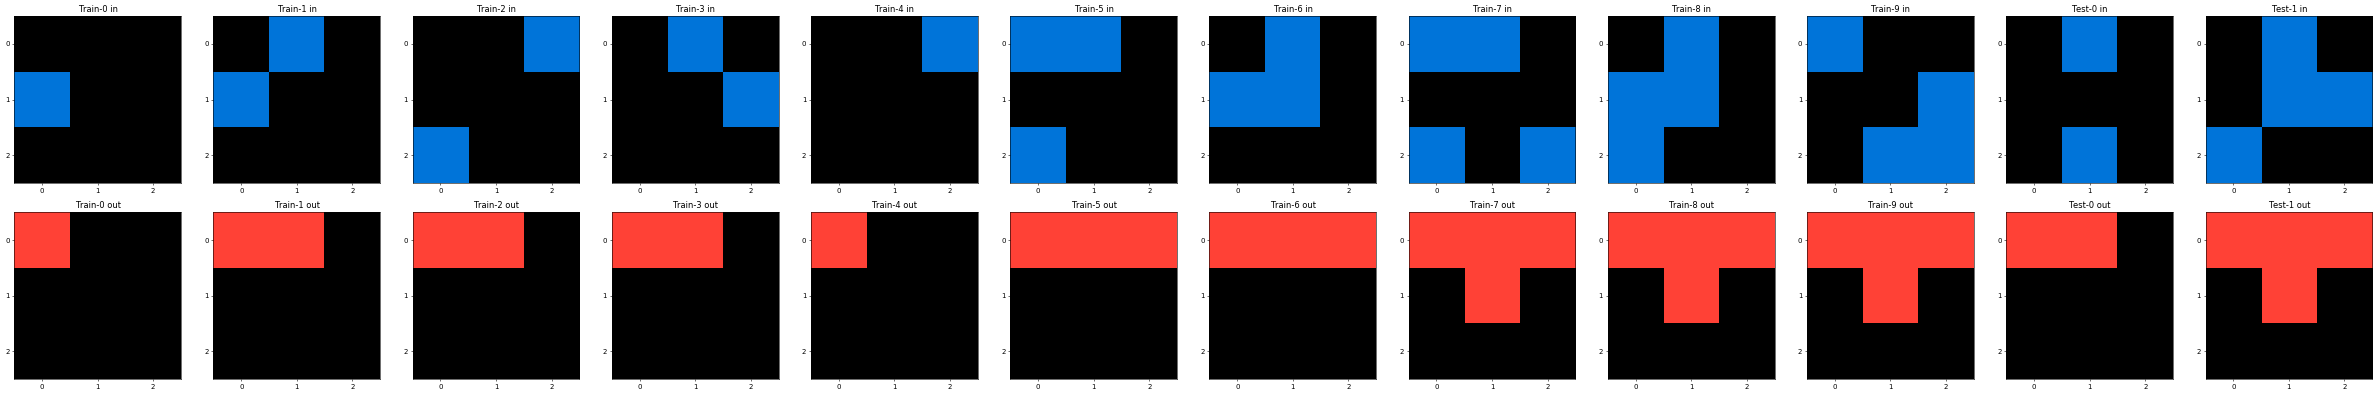

273 0


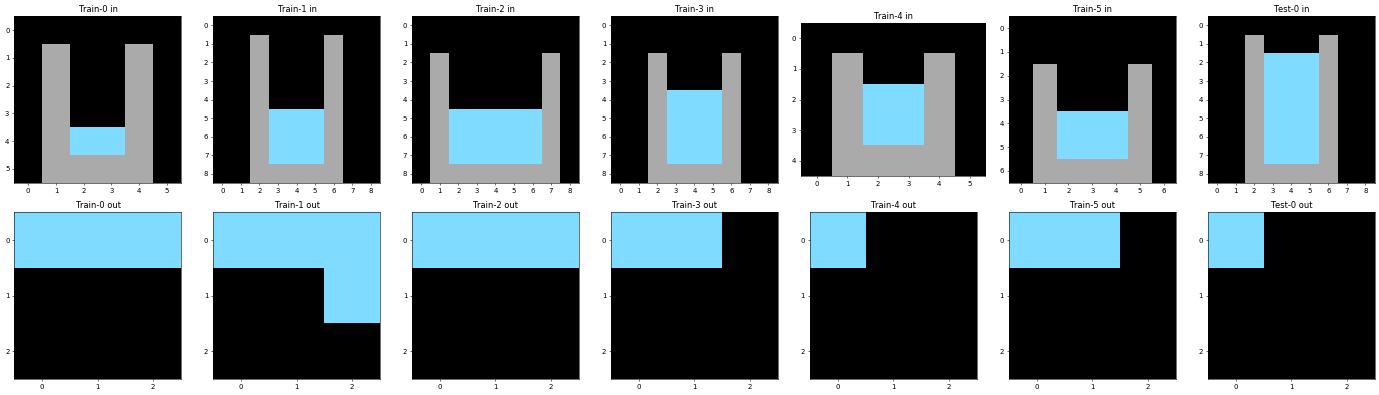

333 0


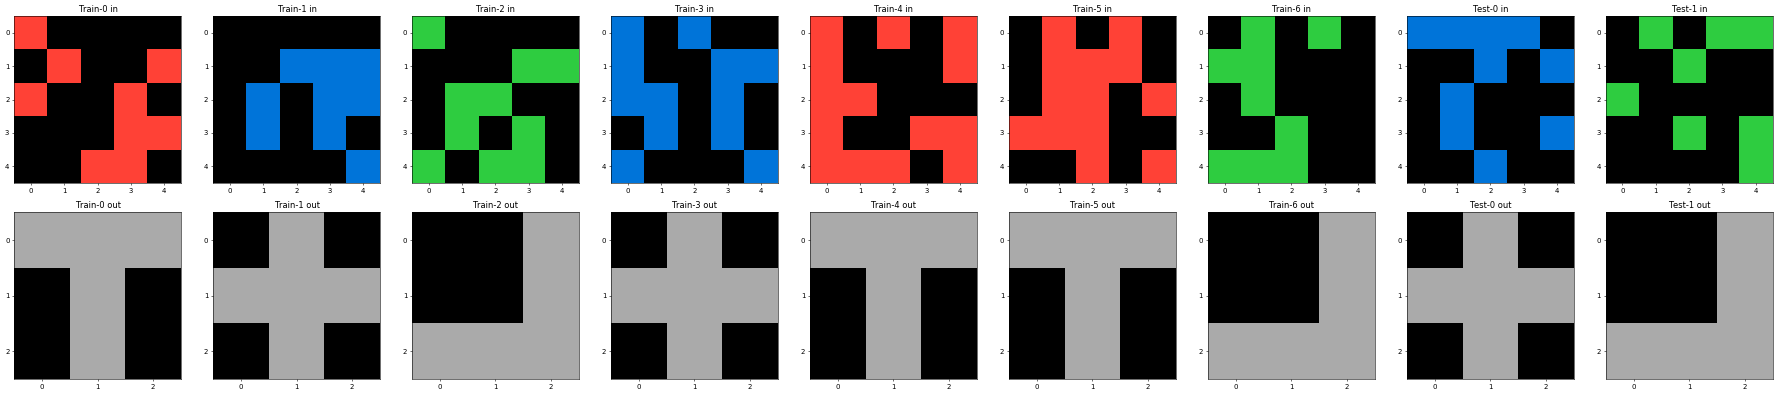

333 1


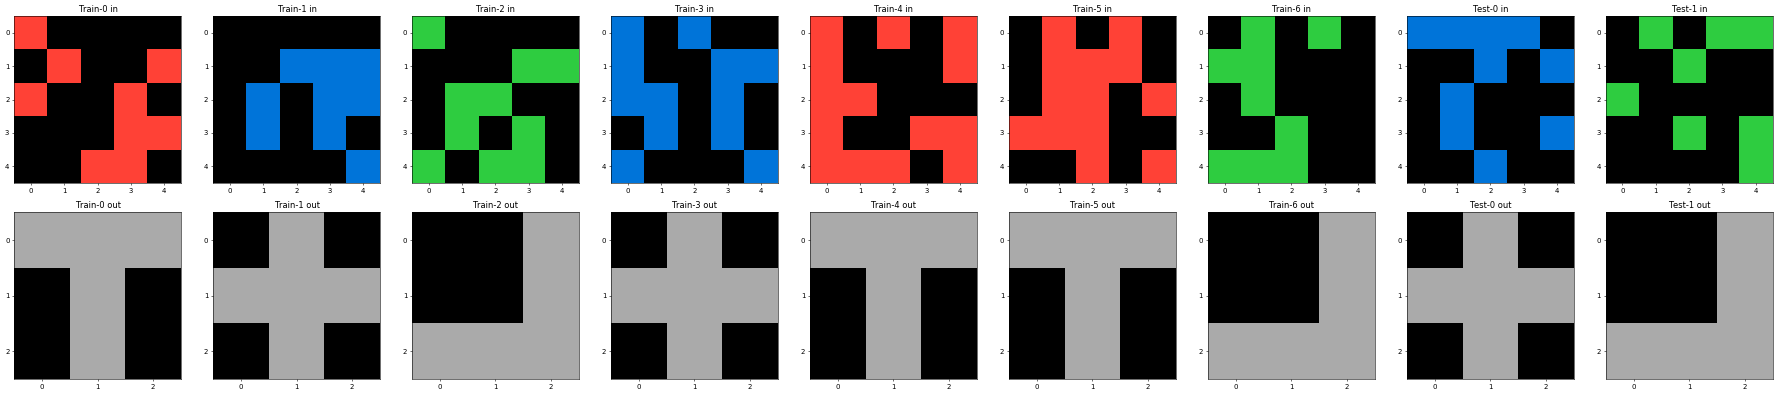

345 0


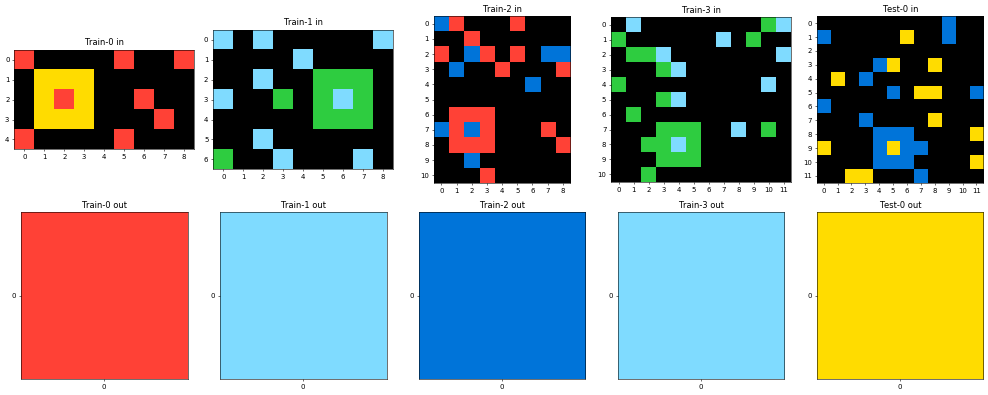

398 0


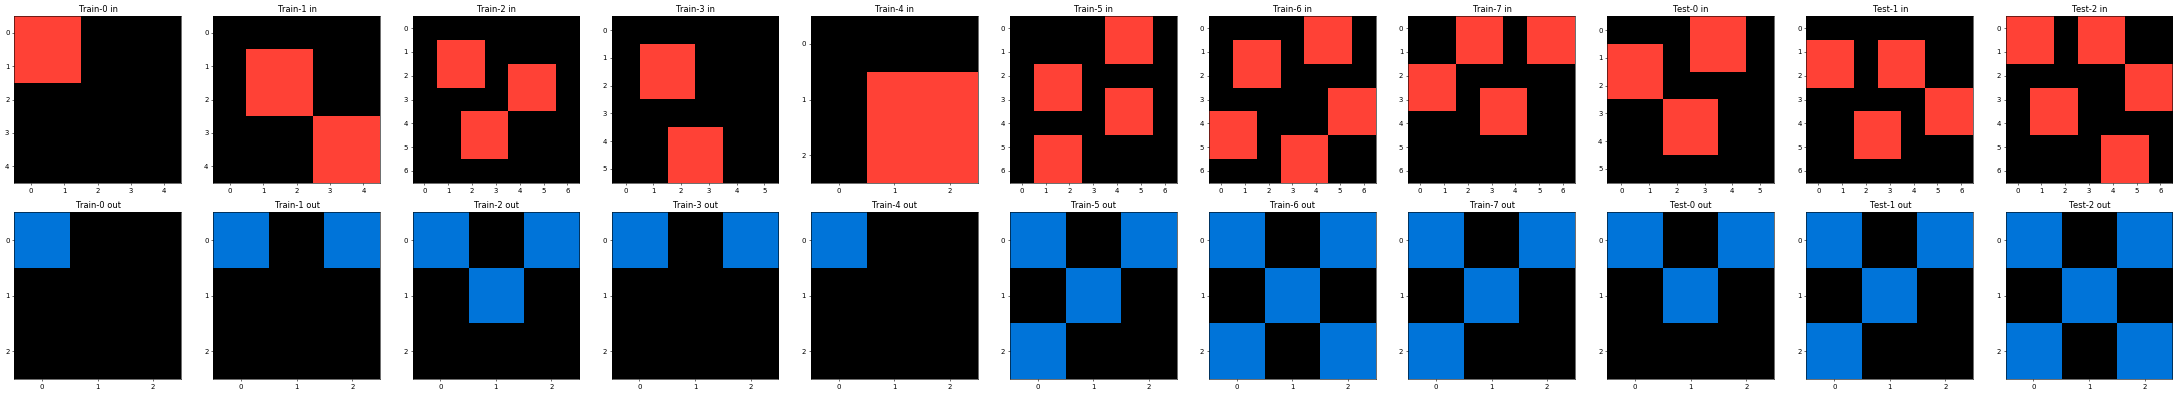

398 1


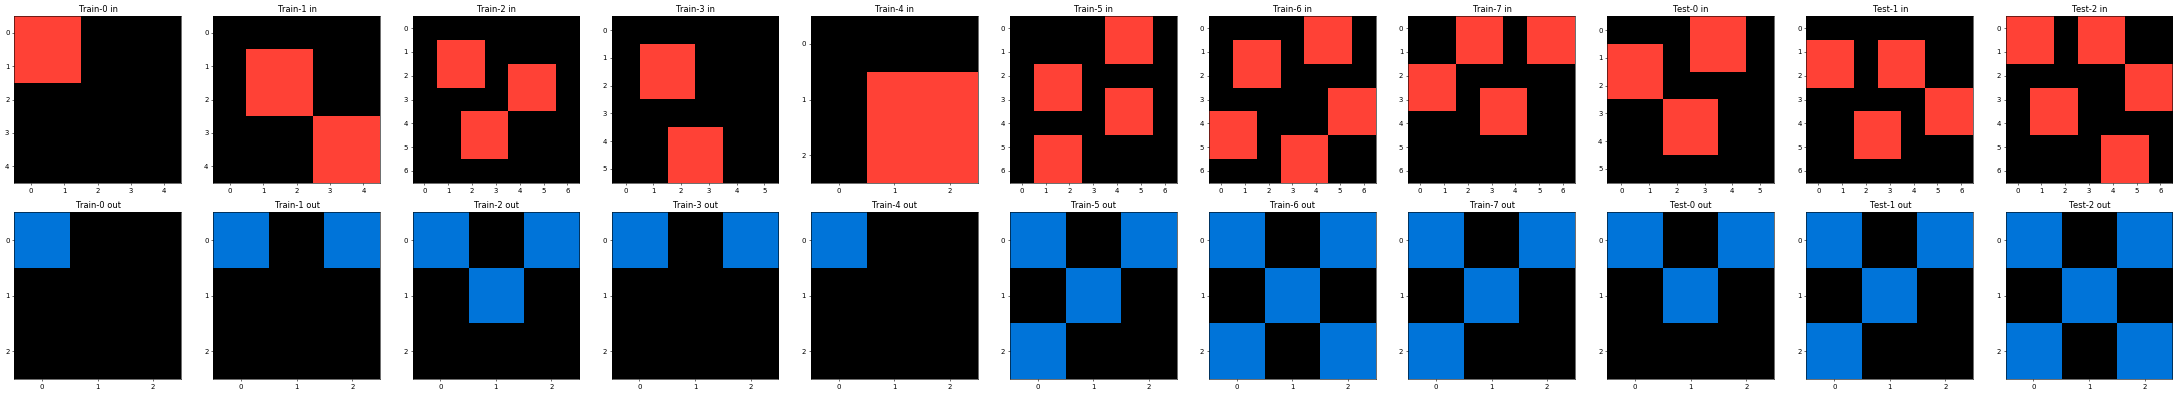

398 2


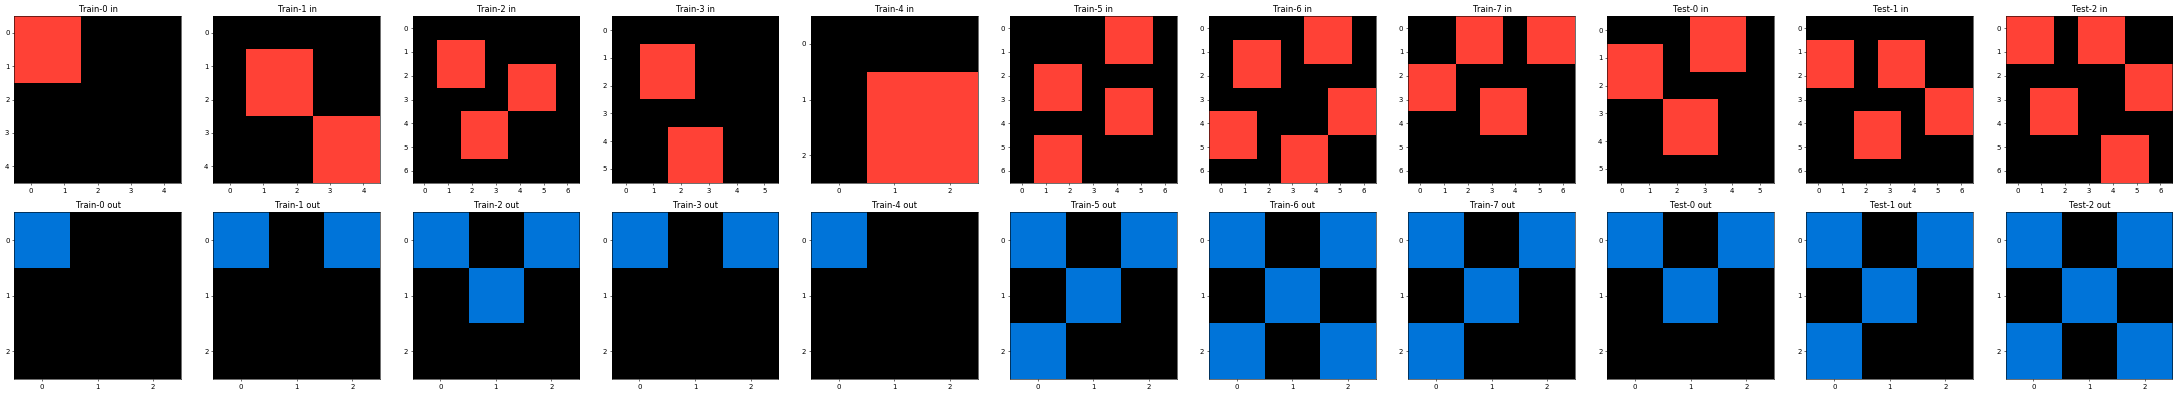

In [11]:
for i in range(400):
    task = Trains[i]
    k = len(task['test'])
    for j in range(k):
        basic_task = Create(task, j)
        proposed_solution = search_same_output(basic_task)
        if proposed_solution != -1:
            print(i,j)
            
            plot_task(task)

In [50]:
# def solve_same_output(basic_task):
#     Input = [Defensive_Copy(x) for x in basic_task[0]]
#     Output = [Defensive_Copy(y) for y in basic_task[1]]
#     Test_Case = Input[-1]
#     Input = Input[:-1]
#     list1=[]
#     solved=False
#     for x, y in zip(Input,Output):
#         if y not in list1:
#             list1.append(y)
#         else:
#             solved=True
#     if solved==False:
#         return -1
#     else:
#         return list1

42 0


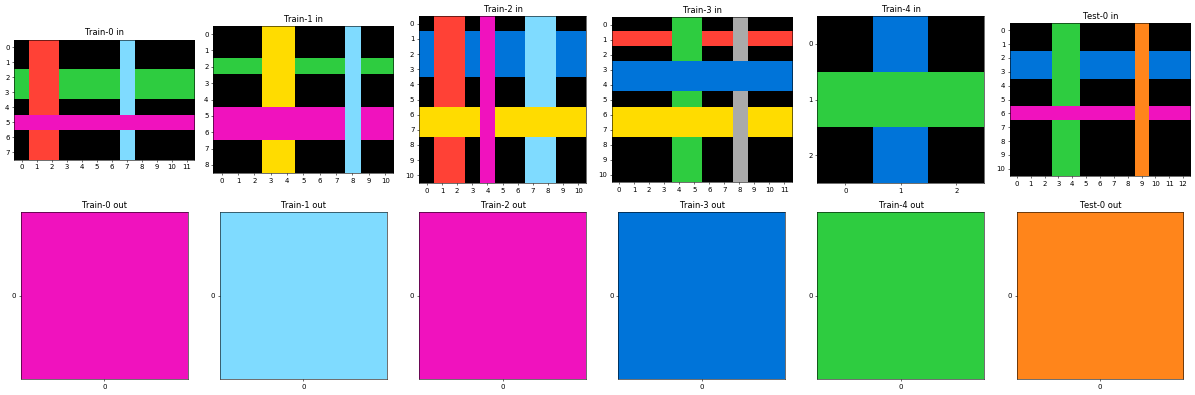

92 0


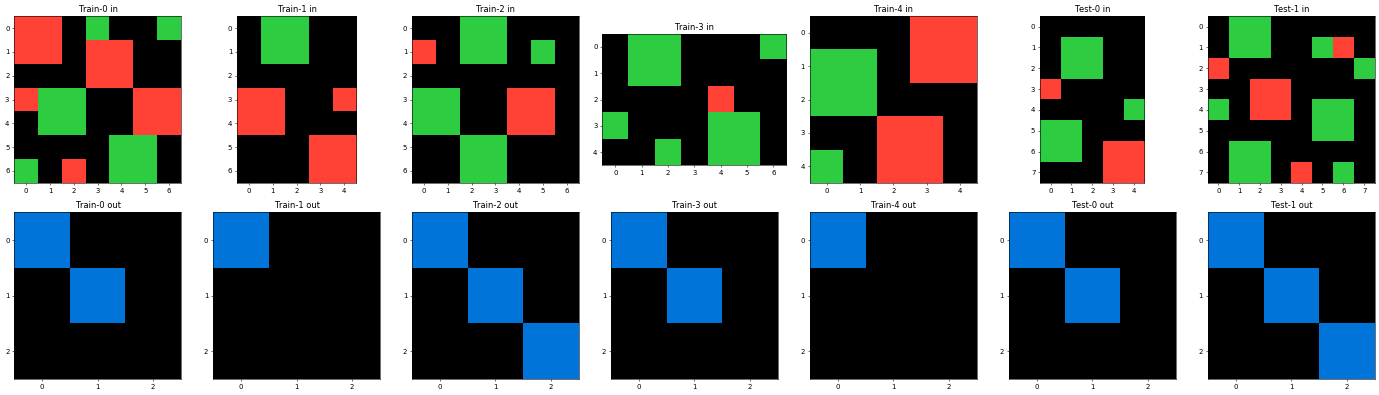

92 1


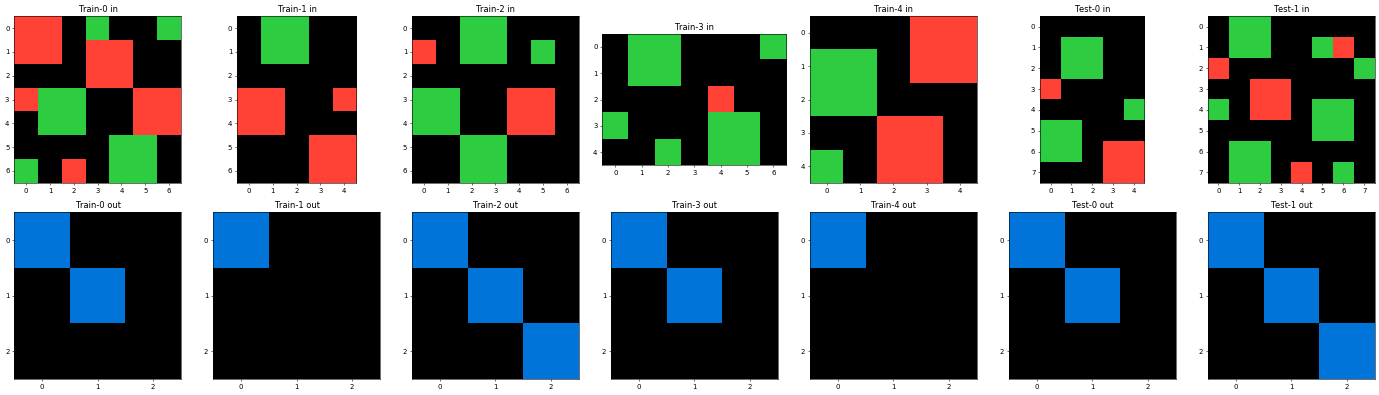

200 0


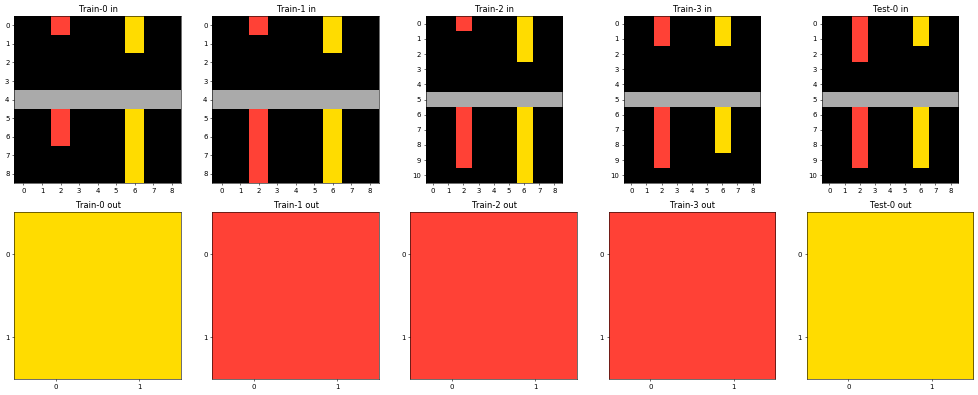

217 0


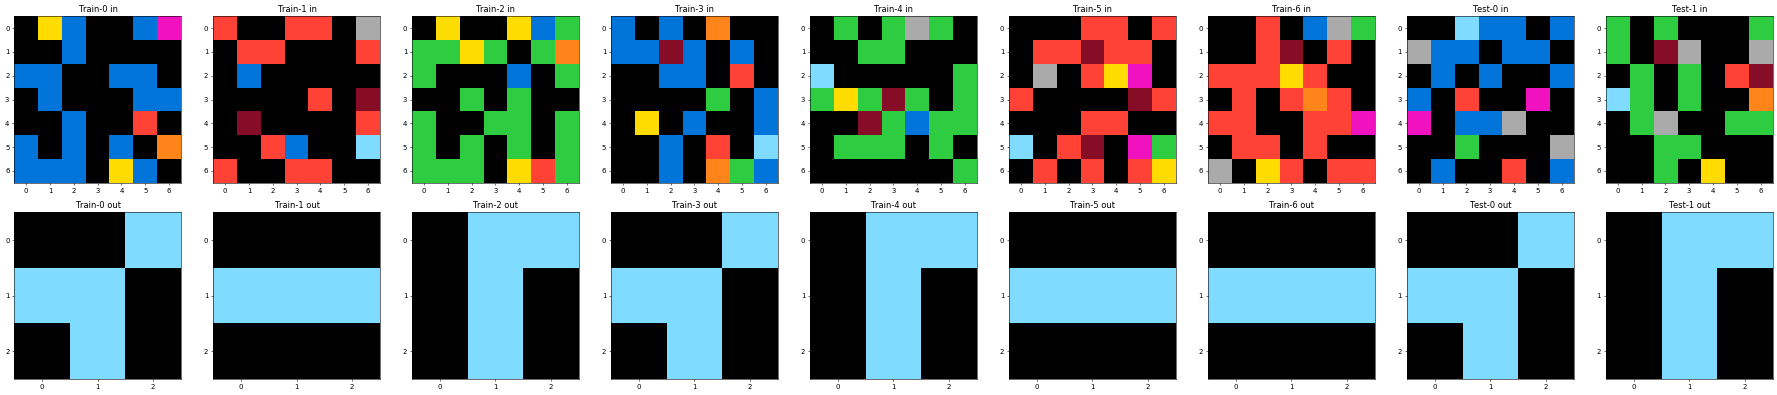

217 1


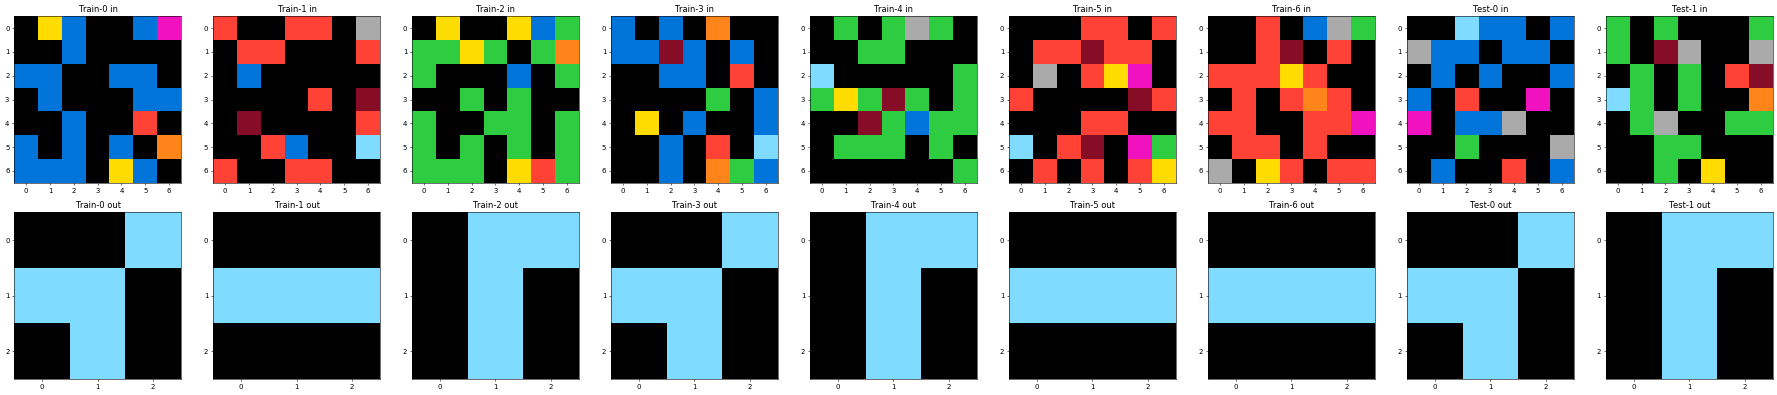

271 0


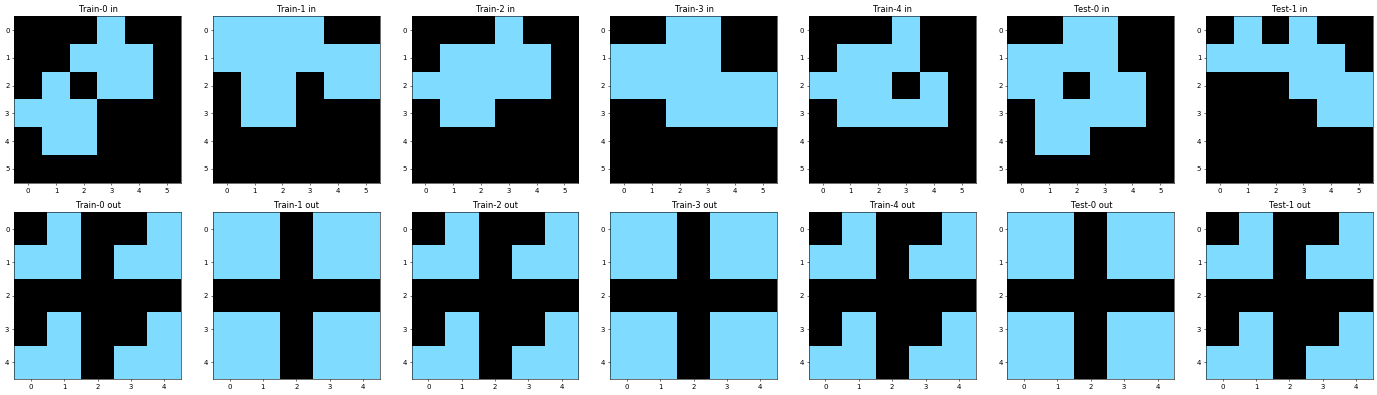

271 1


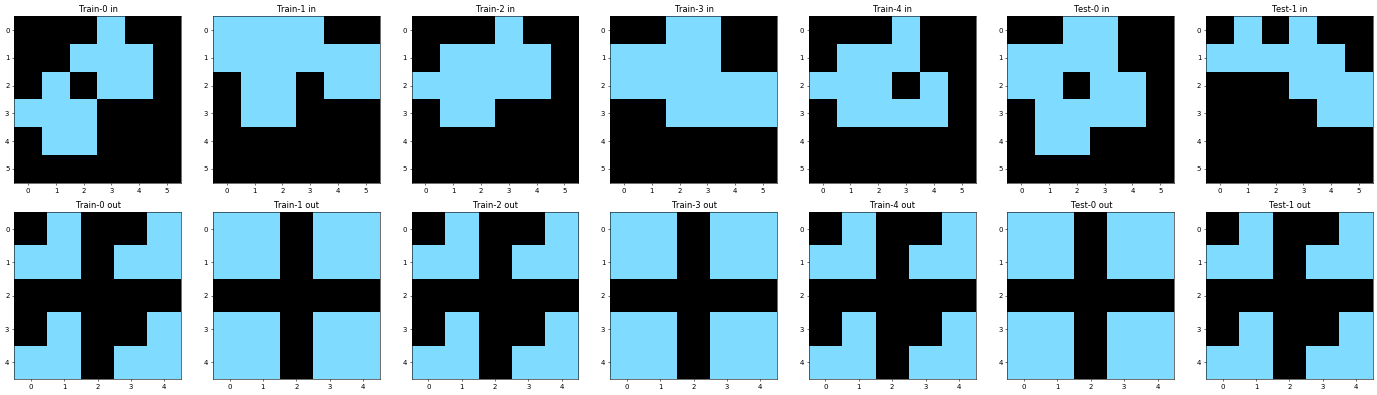

In [22]:
for i in range(400):
    task = Evals[i]
    k = len(task['test'])
    for j in range(k):
        basic_task = Create(task, j)
        proposed_solution = solve_same_output(basic_task)
        if proposed_solution != -1:
            print(i,j)
            plot_task(task)

In [13]:
def search_same_output_colormap(basic_task):
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    target=Output[0]
    for x, y in zip(Input,Output):
        if checkColorMap(target,y)==False:
            return -1
    return True

36 0


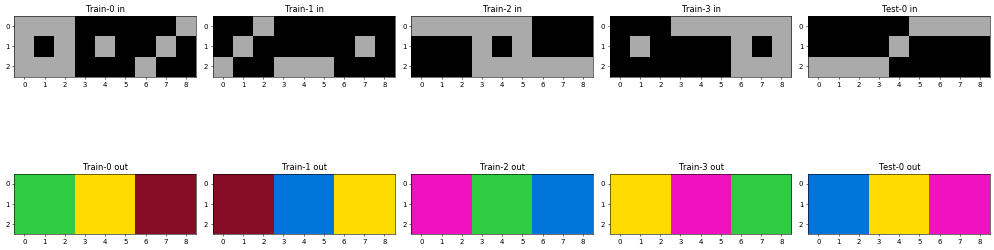

42 0


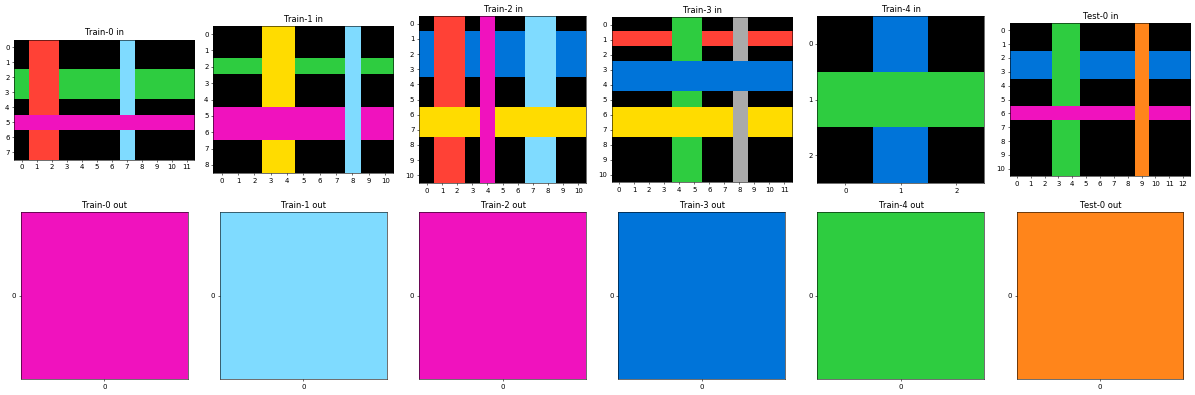

77 0


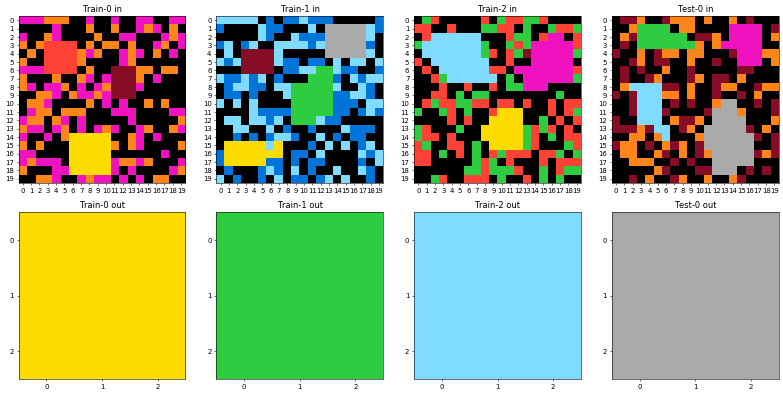

90 0


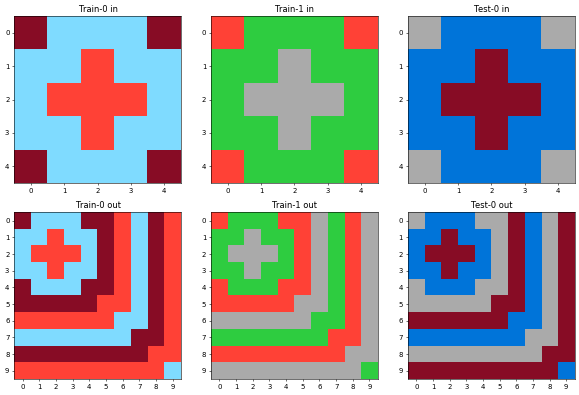

134 0


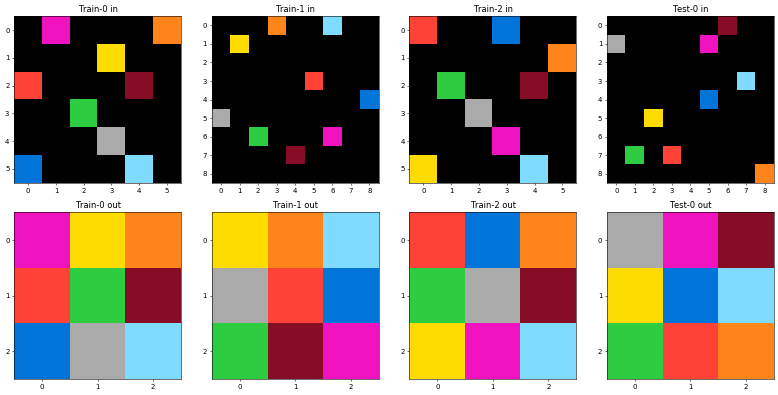

154 0


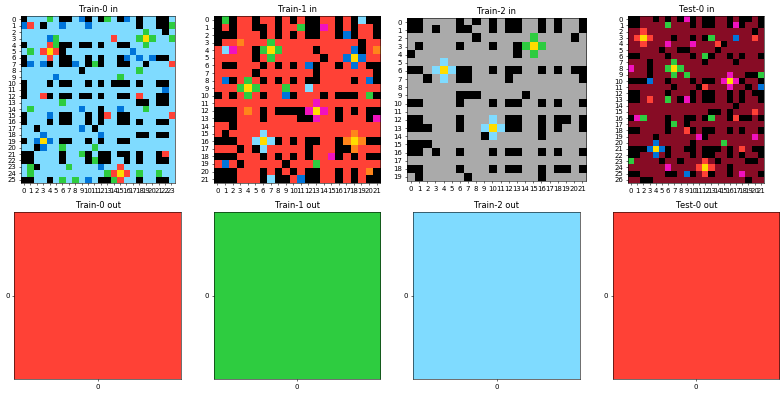

156 0


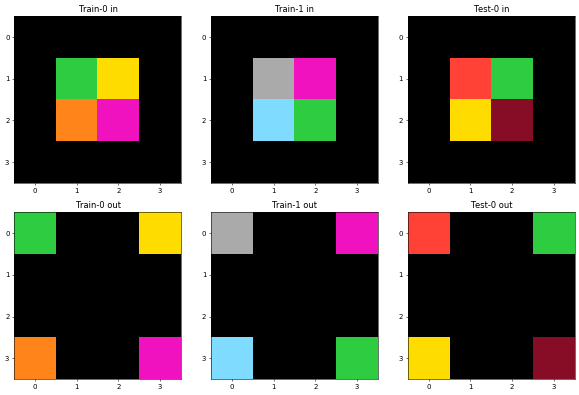

200 0


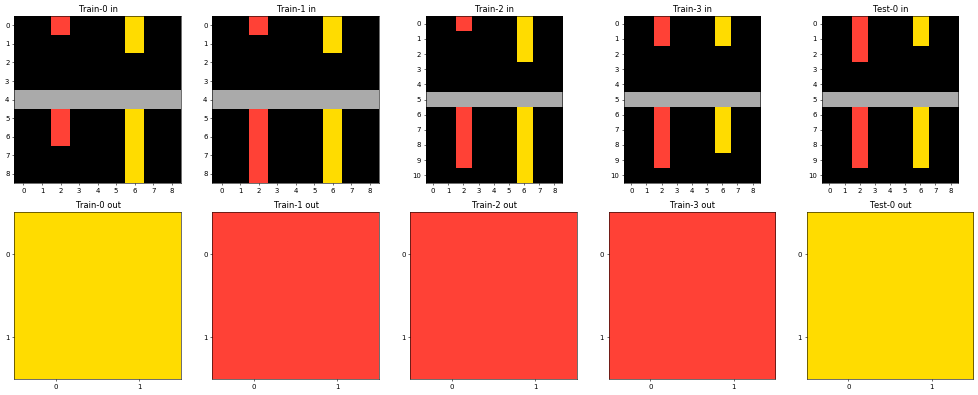

290 0


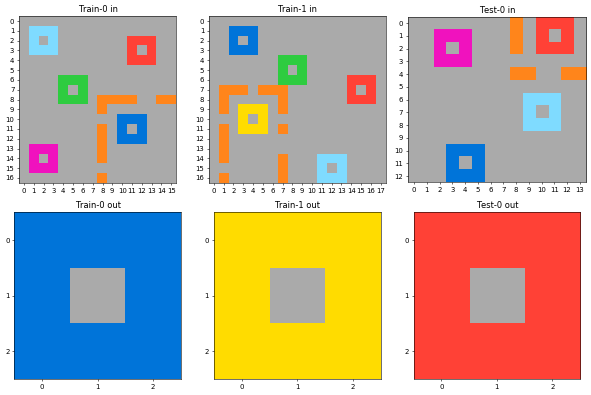

307 0


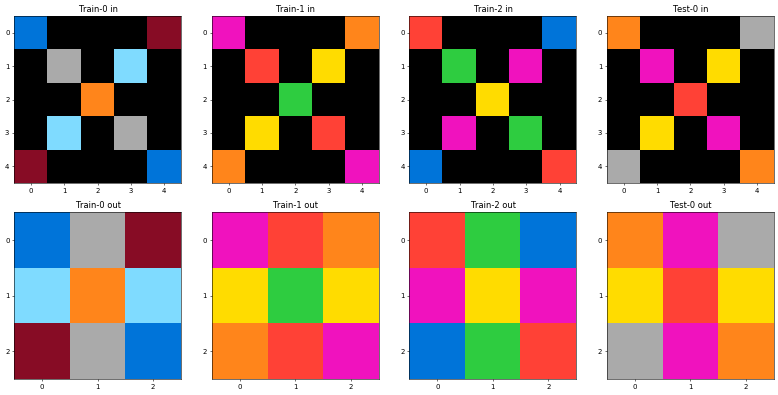

In [15]:
for i in range(400):
    task = Evals[i]
    k = len(task['test'])
    for j in range(k):
        basic_task = Create(task, j)
        proposed_solution = search_same_output_colormap(basic_task)
        if proposed_solution != -1:
            print(i,j)
            
            plot_task(task)

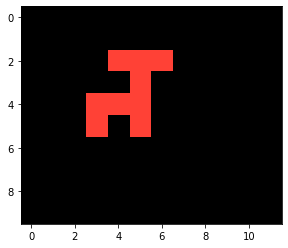

1

In [38]:
a=Trains[30]["train"][0]["input"]
plot_picture(a)
len(split_object8(a))

In [44]:
def search_object_output(basic_task):
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    
    for x, y in zip(Input,Output):
        pattern=[]
        x_list=split_object01(x)
        for i in range(len(x_list)):
            if x_list[i]["obj"] not in pattern:
                pattern.append(x_list[i]["obj"])
        if y not in pattern:
            return -1
    return 1

73 0


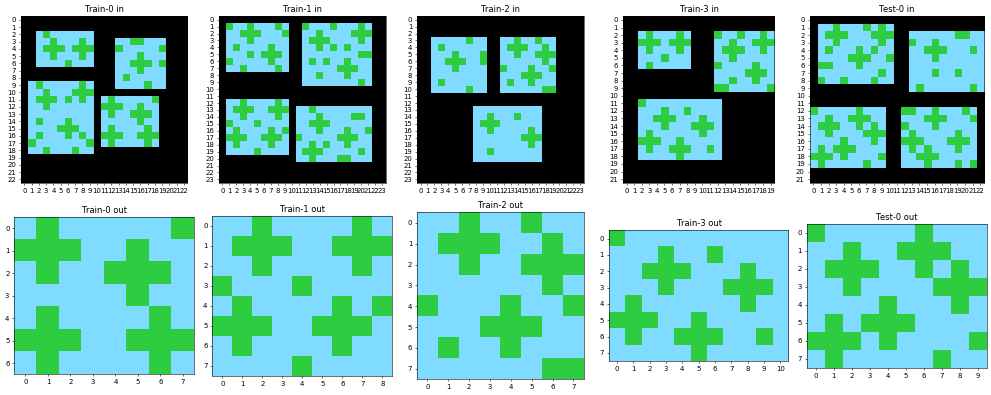

88 0


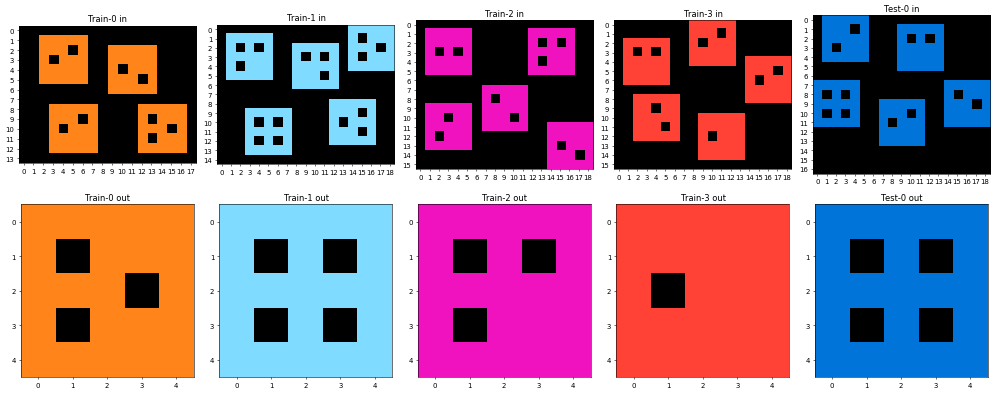

186 0


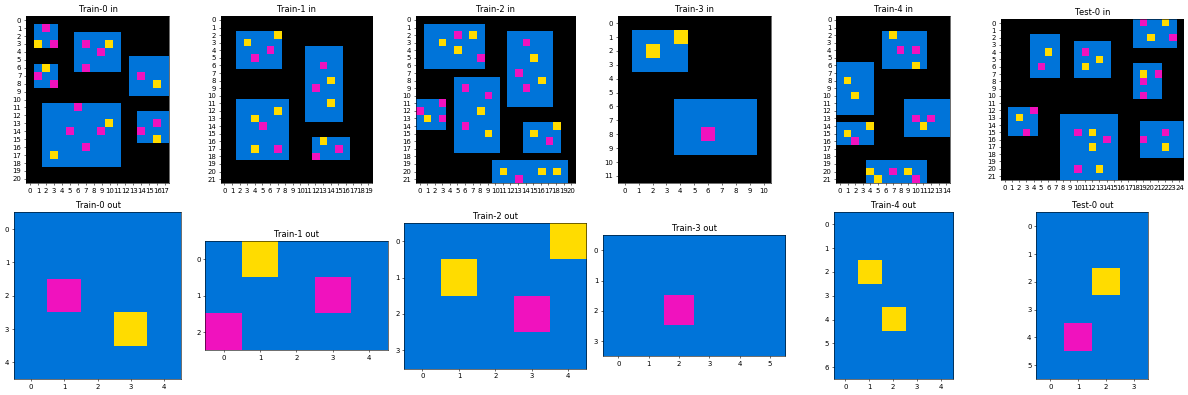

235 0


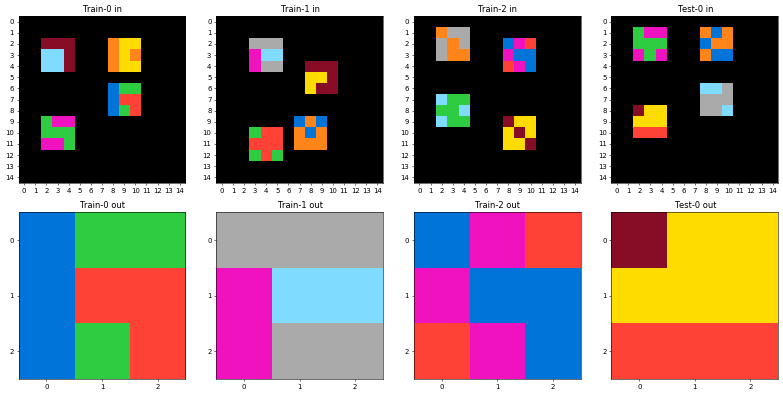

312 0


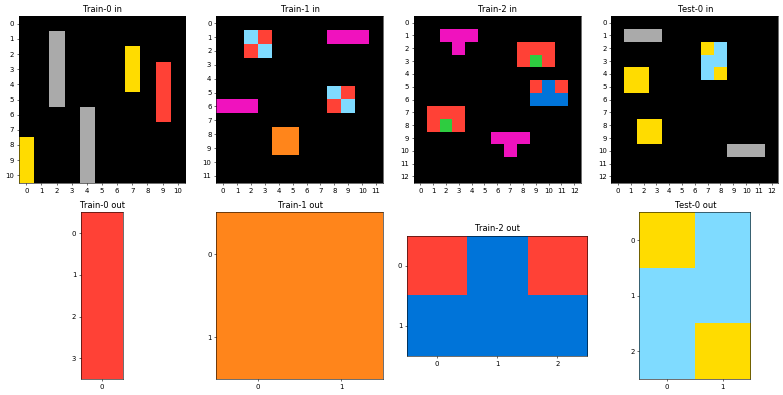

385 0


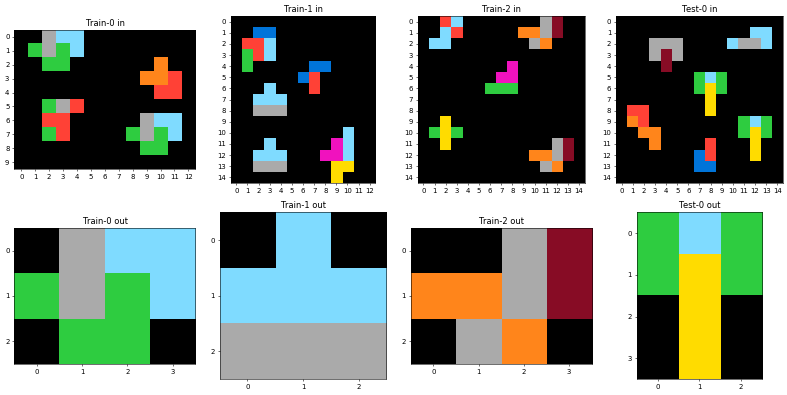

In [45]:
for i in range(400):
    task = Evals[i]
    k = len(task['test'])
    for j in range(k):
        basic_task = Create(task, j)
        proposed_solution = search_object_output(basic_task)
        if proposed_solution != -1:
            print(i,j)
            
            plot_task(task)

In [46]:
def solve_object_output(basic_task):
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    
    for x, y in zip(Input,Output):
        pattern=[]
        x_list=split_object01(x)
        for i in range(len(x_list)):
            if x_list[i]["obj"] not in pattern:
                pattern.append(x_list[i]["obj"])
        if y not in pattern :
            return -1
    pattern_pred=[]
    Test_Case_list=split_object01(Test_Case)
    for i in range(len(Test_Case_list)):
        if Test_Case_list[i]["obj"] not in pattern_pred:
            pattern_pred.append(Test_Case_list[i]["obj"])
    return pattern_pred

73 0


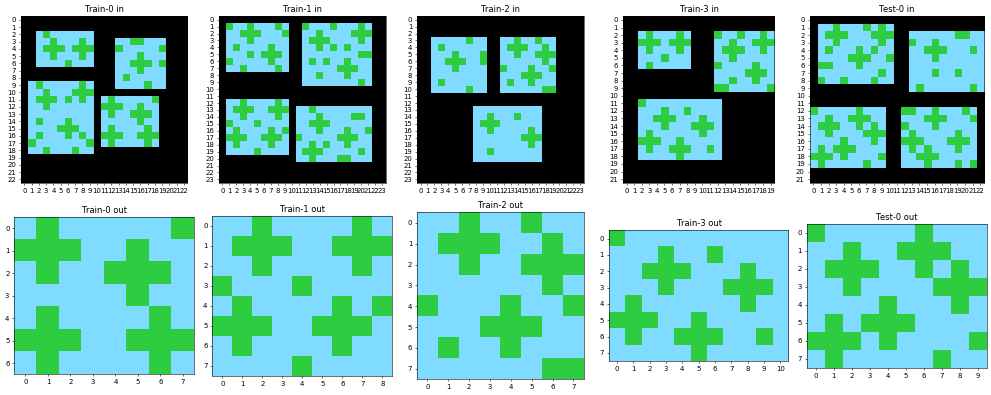

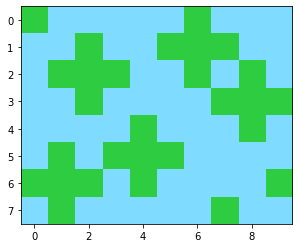

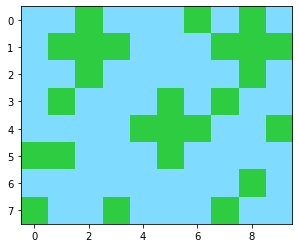

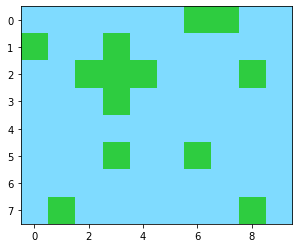

88 0


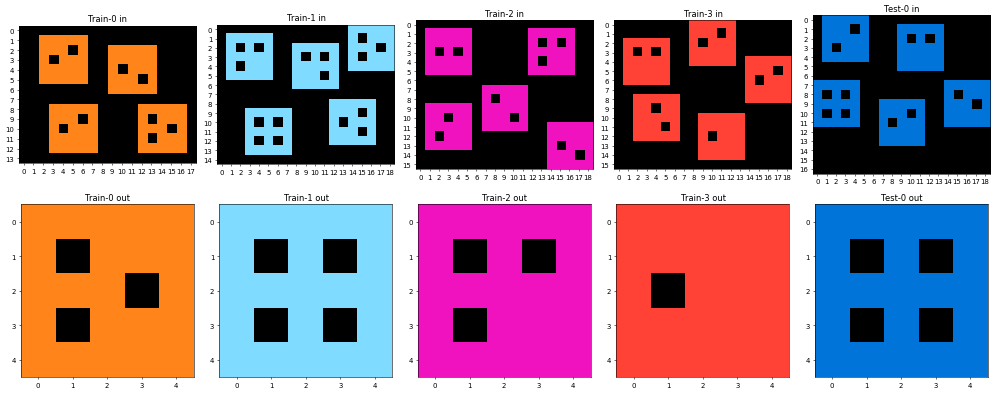

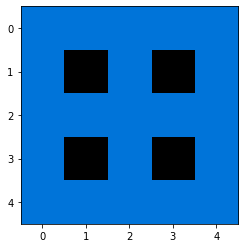

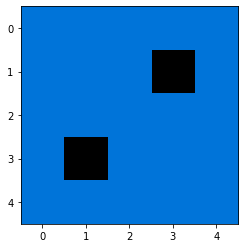

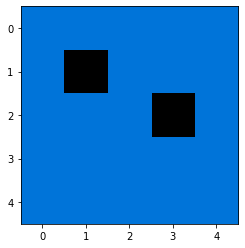

186 0


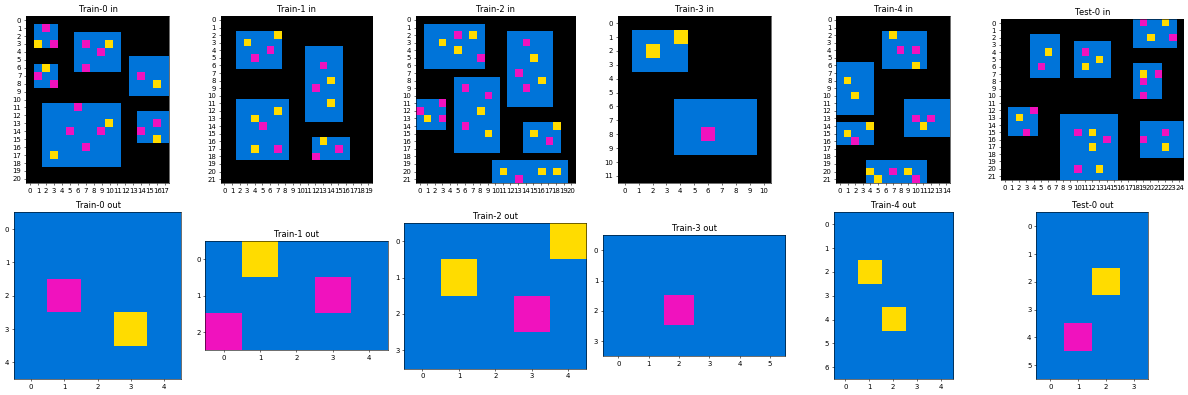

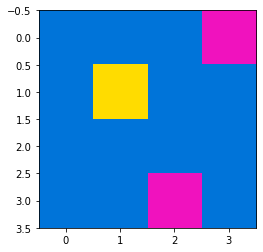

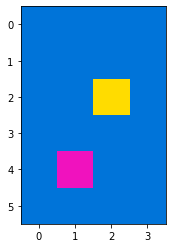

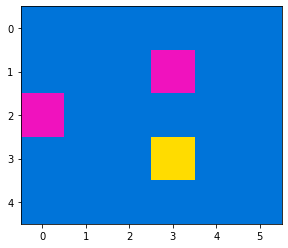

235 0


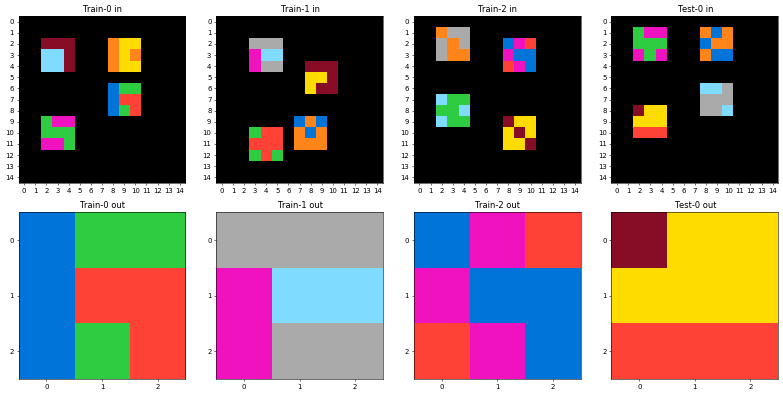

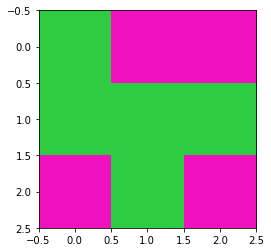

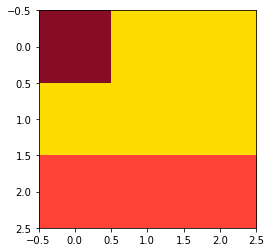

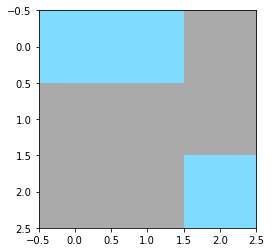

312 0


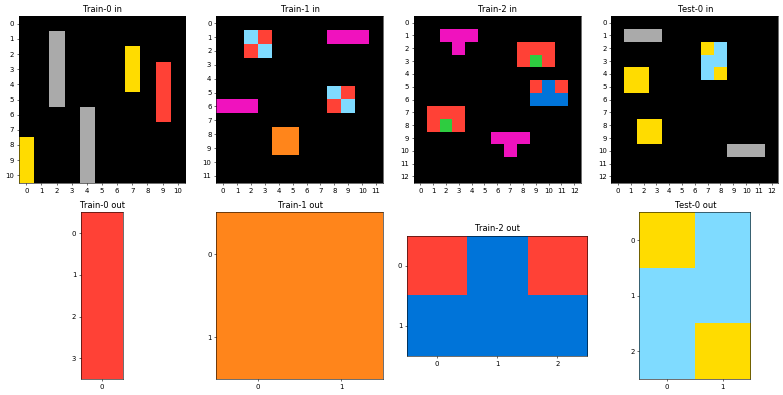

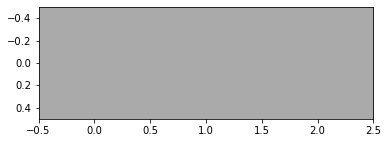

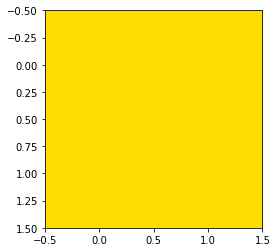

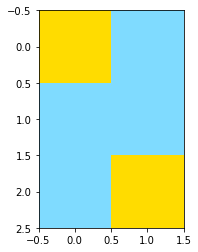

385 0


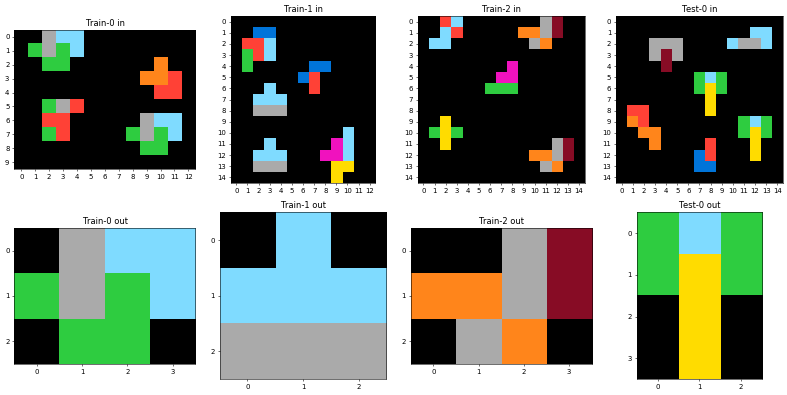

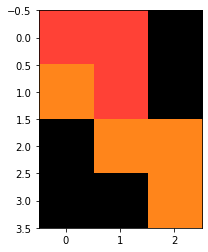

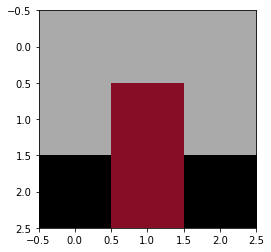

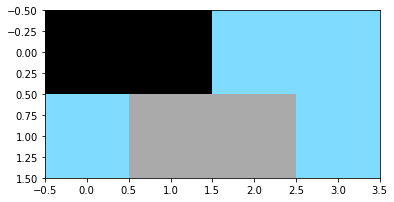

In [49]:
for i in range(400):
    task = Evals[i]
    k = len(task['test'])
    for j in range(k):
        basic_task = Create(task, j)
        proposed_solution = solve_object_output(basic_task)
        if proposed_solution != -1:
            print(i,j)
            plot_task(task)
            plot_picture(proposed_solution[0])
            plot_picture(proposed_solution[1])
            plot_picture(proposed_solution[-1])